# 4.3 Predicting house prices: A regression example

Another common type of machine learning problem is regression, which consists of predicting a continuous value instead of a discrete label

## The Boston Housing Price Dataset
Each data point has 13 numerical features with different scale for each feature.

In [182]:
import numpy as np

In [183]:
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

In [184]:
test_data.shape, train_data.shape

((102, 13), (404, 13))

The targets are the median values of owner-occupied homes, in thousands of dollars

In [185]:
train_data[:10]

array([[1.23247e+00, 0.00000e+00, 8.14000e+00, 0.00000e+00, 5.38000e-01,
        6.14200e+00, 9.17000e+01, 3.97690e+00, 4.00000e+00, 3.07000e+02,
        2.10000e+01, 3.96900e+02, 1.87200e+01],
       [2.17700e-02, 8.25000e+01, 2.03000e+00, 0.00000e+00, 4.15000e-01,
        7.61000e+00, 1.57000e+01, 6.27000e+00, 2.00000e+00, 3.48000e+02,
        1.47000e+01, 3.95380e+02, 3.11000e+00],
       [4.89822e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 6.31000e-01,
        4.97000e+00, 1.00000e+02, 1.33250e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.75520e+02, 3.26000e+00],
       [3.96100e-02, 0.00000e+00, 5.19000e+00, 0.00000e+00, 5.15000e-01,
        6.03700e+00, 3.45000e+01, 5.98530e+00, 5.00000e+00, 2.24000e+02,
        2.02000e+01, 3.96900e+02, 8.01000e+00],
       [3.69311e+00, 0.00000e+00, 1.81000e+01, 0.00000e+00, 7.13000e-01,
        6.37600e+00, 8.84000e+01, 2.56710e+00, 2.40000e+01, 6.66000e+02,
        2.02000e+01, 3.91430e+02, 1.46500e+01],
       [2.83920e-01, 0.00000e+

In [186]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

## Preparing Data
It would be problematic to feed into a neural network values that all take wildly different ranges.
The model might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult. 

<br/>

#### Ok, now what to do?
Do **feature-wise normalization**: for each feature in the input data (a column in the input data matrix), subtract the mean of the feature and divide by the standard deviation, so that the feature is centered around 0 and has a unit standard deviation. 

This is easily done in NumPy:

In [187]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

Two Notes Here:
1. In the case of mean(axis=0), you are calculating the mean along the rows, resulting in an array of mean values for each column (feature) in the 2D array.
2. Note that the quantities used for normalizing the test data are computed using the training data. You should never use any quantity computed on the test data in your workflow, even for something as simple as data normalization. 

```python
train_data.mean(axis=0)
# is equal to
col_mean = []
for col in range(13):
    col_mean.append(train_data[:, col].mean())
print(col_mean)
```
and 
```python
train_data.mean(axis=1)
# is equal to
row_mean = []
for i in range(len(train_data)):
    row_mean.append(reserved_train_data[i, :].mean())
print(row_mean)
```


## Building the Model

In general, the less training data you have, the worse overfitting will be, and using a small model is one way to mitigate overfitting.

In [188]:
from tensorflow import keras
from keras import layers


def get_model() -> keras.Sequential:
    model = keras.Sequential([
        layers.Dense(units=32, activation="relu"),
        layers.Dense(1)
    ])

    model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
    return model


Notes about the Model:
- The model ends with a single unit and no activation (it will be a linear layer).
- This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value).
- Applying an activation function would constrain the range the output can take.
    - if you applied a sigmoid activation function, the model could only learn to predict values between 0 and 1.
    - if you applied a relu activation function, the model could only learn to predict values positive values only, as negative values are set to zero.

Notes about the Loss and Function and the Metrics:
- MSE loss function: mean squared error, the square of the difference between the predictions and the targets.
    - This is a widely used loss function for regression problems.
- Mean Absolute Error (MAE): It’s the absolute value of the difference between the predictions and the targets.



## K-Fold Validation
When we have a small amount of data, it's not the smartest to split the data into validation and training. The validation scores might have a high variance with regard to the validation split 

So, we can use K-fold cross-validation.

It consists of splitting the available data into K partitions, instantiating K identical models, and training each one on K – 1 partitions while evaluating on the remaining partition.

The **Validation Score** for the model used is then the average of the K validation scores obtained

In [189]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100 
all_mae_histories = [] 

for i in range(k):
    print(f"Processing fold {i}")
    # 1- splitting the available data into K partitions
    val_data = train_data[num_val_samples * i: num_val_samples * (i + 1)]
    val_targets = train_targets[num_val_samples * i: num_val_samples * (i + 1)]
    partial_train_data = np.concatenate([train_data[:num_val_samples * i], train_data[num_val_samples * (i + 1):]],
                                        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:num_val_samples * i], train_targets[num_val_samples * (i + 1):]],
        axis=0)
    model = get_model()
    # 2- training each one on K – 1 partitions
    # (in silent mode, verbose = 0)
    history = model.fit(partial_train_data, partial_train_targets,          
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=16, verbose=0)
    mae_history = history.history["val_mae"]
    all_mae_histories.append(mae_history)


Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [190]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
print(average_mae_history)

[22.269521713256836, 22.149423122406006, 22.02499485015869, 21.884631633758545, 21.732482433319092, 21.56318187713623, 21.377384185791016, 21.177974224090576, 20.966572761535645, 20.73258638381958, 20.490710258483887, 20.229124546051025, 19.952550411224365, 19.66976547241211, 19.380109786987305, 19.08090591430664, 18.777060508728027, 18.46477222442627, 18.145376682281494, 17.827894687652588, 17.508283138275146, 17.17780637741089, 16.85967493057251, 16.537553071975708, 16.220743656158447, 15.898634433746338, 15.58087944984436, 15.2647864818573, 14.943011045455933, 14.621608257293701, 14.311626195907593, 13.99391508102417, 13.683997392654419, 13.374622344970703, 13.05983853340149, 12.750230312347412, 12.435481548309326, 12.11997652053833, 11.821502447128296, 11.508086681365967, 11.183340311050415, 10.87466835975647, 10.556470155715942, 10.24358606338501, 9.927438974380493, 9.621706008911133, 9.30443286895752, 8.998391389846802, 8.679188132286072, 8.391399264335632, 8.074153661727905, 7.7

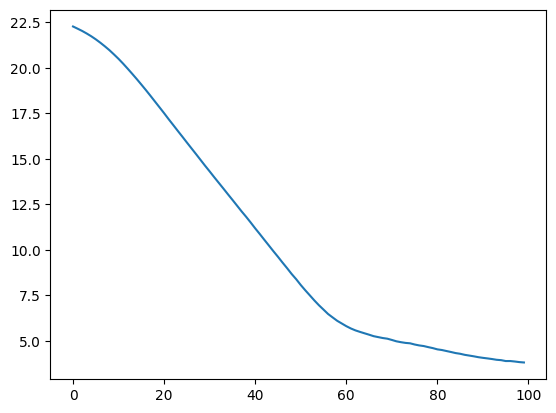

In [191]:
import matplotlib.pyplot as plt
plt.plot(list(range(num_epochs)), average_mae_history)

Once you’re finished tuning other parameters of the model (in addition to the number of epochs, you could also adjust the size of the intermediate layers), you can train a final production model on all of the training data, with the best parameters, and then look at its performance on the test data.

In [192]:
model = get_model()
model.fit(train_data, train_targets, epochs=num_epochs, batch_size=16)
mse_score, mae_score = model.evaluate(test_data, test_targets)

Epoch 1/100
26/26 [==============================] - 1s 22ms/step - loss: 580.0578 - mae: 22.2245
Epoch 2/100
26/26 [==============================] - 0s 6ms/step - loss: 561.7540 - mae: 21.9990
Epoch 3/100
26/26 [==============================] - 0s 5ms/step - loss: 545.7928 - mae: 21.7539
Epoch 4/100
26/26 [==============================] - 0s 5ms/step - loss: 529.3370 - mae: 21.4920
Epoch 5/100
26/26 [==============================] - 0s 5ms/step - loss: 513.3914 - mae: 21.2304
Epoch 6/100
26/26 [==============================] - 0s 6ms/step - loss: 497.1768 - mae: 20.9268
Epoch 7/100
26/26 [==============================] - 0s 5ms/step - loss: 479.6078 - mae: 20.5482
Epoch 8/100
26/26 [==============================] - 0s 5ms/step - loss: 461.9442 - mae: 20.1827
Epoch 9/100
26/26 [==============================] - 0s 5ms/step - loss: 444.8727 - mae: 19.8024
Epoch 10/100
26/26 [==============================] - 0s 5ms/step - loss: 427.2317 - mae: 19.3738
Epoch 11/100
26/26 [========

In [193]:
mse_score, mae_score

(18.74355697631836, 3.1546361446380615)

## Generating predictions on new data
With this scalar regression model, predict() returns the model’s guess for the sample’s price in thousands of dollars.

In [194]:
predictions = model.predict(test_data)
predictions[:10]

4/4 [==============================] - 0s 5ms/step


array([[10.08905 ],
       [19.767208],
       [21.272879],
       [31.689709],
       [24.62602 ],
       [20.632244],
       [30.065685],
       [24.258972],
       [18.622303],
       [22.107395]], dtype=float32)

## Wrap Up
- Regression is done using different loss functions than we used for classification. Mean squared error (MSE) is a loss function commonly used for regression.
- Similarly, evaluation metrics to be used for regression differ from those used for classification; naturally, the concept of accuracy doesn’t apply for regression. A common regression metric is mean absolute error (MAE).
- When features in the input data have values in different ranges, each feature should be scaled independently as a preprocessing step.
- When there is little data available, using K-fold validation is a great way to reliably evaluate a model.
- When little training data is available, it’s preferable to use a small model with few intermediate layers (typically only one or two), in order to avoid severe overfitting. 